In [ ]:
# Data:
# num documents annotated: 192
# num connections drawn: 1260
# num possible connections: 16853
# num nodes: 3570


# results
# ----------------------------------------
# 

# subsequence-1:         86.0
# subsequence-2:         88.7
# subsequence-3:         88.5
# subsequence-4:         88.2

# bleu-1:                86.7
# bleu-2:                89.2
# bleu trigram:          88.8
# bleu mixed bigram      88.8
# bleu mixed trigram     89.1

# hungarian word-matching, BERT-mini:   88.5
# hungarian word-matching, BERT-medium: 88.7
# hungarian word-matching, RoBERTa:     88.7
# max word-matching BERT-mini:          89.0
# max word-matching BERT-medium:        89.5

# SequenceMatcher ratio:                89.5

In [1]:
# Thoughts EDA for edits:
# - top words for additions
# - top words for deletions 
# - how many times a contributor is added? (Authorship model)
# - how many times a correction is issued
# - how many times a headline is updated
# - how many refuters occur
# - discourse tags of additions/edits/deletions
# - how often are DATES, people, other NEs added?
# - When are sentences removed:
#     hypotheses:
#     --------------------------------------------------------------
#         "it's not immediately clear"
#         "no information"
#         "trying to determine"
#         "yet to establish"
#         "no official word"
#         "still being compiled"
#         "more details soon"
#         "not yet known"
#         "cause not determined"
#         "check back for updates"


# build annotation framework:
# -----------------------------------------------
# for each sentence in a document
# 1. Add sentence before/after
# 2. Delete sentence
# 3. Move sentence to position 1, 2, 3...


# take current dataset, train a model
# then we will have more confidence
# if the model is very good, then we wil be concerned 
# 
# start with human-annotated editing data
# then add the distantly-supervised data
# 

In [2]:
import pandas as pd 
import glob
import ast
import pickle
import numpy as np 
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.rc('font', size=14)

In [3]:
with open('hits_cache/2021-10-24__all-answers.pkl', 'rb') as f:
    all_answers = pickle.load(f)    

In [129]:
n_connect = 0
n_nodes = 0
num_possible_connects = 0
for a in all_answers:
    n_connect += len(a['annotated connections'])
    n_nodes += len(a['nodes'])
    versions = list(map(lambda x: x['version'], a['nodes']))
    v_x = min(versions)
    v_y = max(versions)
    n_v_x = len(list(filter(lambda x: x == v_x, versions)))
    n_v_y = len(list(filter(lambda x: x == v_y, versions)))
    num_possible_connects += n_v_x * n_v_y

In [115]:
len(all_answers)

193

In [4]:
doc_ids = list(map(lambda x: x['doc_id'], all_answers))
doc_ids = list(map(ast.literal_eval, doc_ids))
doc_ids = list(set(doc_ids))
doc_ids = sorted(doc_ids, key=lambda x: x[0])

In [5]:
annotated_doc_ids = pd.DataFrame(doc_ids, columns=['source', 'entry_id', 'version_x', 'version_y'])

In [943]:
spark_output_csv = pd.read_csv('tmp/output-word-distance-.5-sent-dist-1.csv', index_col=0)

In [944]:
doc_ids = list(map(lambda x: ast.literal_eval(x['doc_id']), all_answers))
doc_ids_df = (
    pd.DataFrame(doc_ids, columns=['source', 'entry_id', 'version_x', 'version_y'])
     .assign(key=lambda df: df.apply(lambda x: (x['source'], x['entry_id'], x['version_x'], x['version_y']),axis=1))
     .drop_duplicates()
)

In [945]:
spark_output_csv = spark_output_csv.merge(
    doc_ids_df,
    how='left',
    left_on=['entry_id', 'version_x', 'version_y'],
    right_on=['entry_id', 'version_x', 'version_y']
)

In [946]:
all_answers_df = (pd.DataFrame(all_answers)
 .assign(doc_id=lambda df: df['doc_id'].apply(ast.literal_eval))
 .set_index('doc_id')
)

In [952]:
all_prec_recall = []
all_comparisons = []

for a in tqdm(all_answers):
    pred_arcs = (
        spark_output_csv
         .loc[lambda df: df['key'] == ast.literal_eval(a['doc_id'])]
         .fillna(1)
    )
    if len(pred_arcs) > 0:
    #     pred_arcs = pd.DataFrame(a['original_arcs'])
        annotated_arcs = pd.DataFrame(a['annotated connections'], columns=['sent_idx_x', 'sent_idx_y']).astype(int)

        for max_distance in np.arange(0, .6, .02):
            pred_arcs_test = (
                pred_arcs
                  .loc[lambda df: df[['avg_sentence_distance_x', 'avg_sentence_distance_y']].min(axis=1) < max_distance]
                 [['sent_idx_x', 'sent_idx_y']].astype(int)
            )

            comparison = (
                pred_arcs_test.assign(in_pred=True)
                 .merge(
                     annotated_arcs.assign(in_annot=True),
                     how='outer',
                     left_on=['sent_idx_x', 'sent_idx_y'],
                     right_on=['sent_idx_x', 'sent_idx_y'],
                   )
                 .fillna(False)
                .assign(cutoff=max_distance)
                )


            all_comparisons.append(comparison)

all_comparison_df = pd.concat(all_comparisons)

  0%|          | 0/193 [00:00<?, ?it/s]

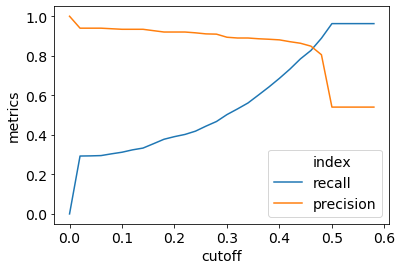

In [953]:
prec_recall = (all_comparison_df
 .groupby('cutoff')
 .mean()
 .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
 [['recall', 'precision']]
 .stack()
 .reset_index()
 .rename(columns={0: 'metrics', 'level_1': 'index'})
)

sns.lineplot(data=prec_recall, y='metrics', x='cutoff', hue='index')

In [954]:
(all_comparison_df
 .groupby('cutoff')
 .mean()
 .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
 .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
#  .max()
)

cutoff
0.00    0.000000
0.02    0.446508
0.04    0.447385
0.06    0.449135
0.08    0.459024
0.10    0.467835
0.12    0.481194
0.14    0.491046
0.16    0.513581
0.18    0.535547
0.20    0.548787
0.22    0.559616
0.24    0.574718
0.26    0.597006
0.28    0.617539
0.30    0.643319
0.32    0.665203
0.34    0.688264
0.36    0.716528
0.38    0.743872
0.40    0.771166
0.42    0.795975
0.44    0.821959
0.46    0.837622
0.48    0.844970
0.50    0.692191
0.52    0.692191
0.54    0.692191
0.56    0.692191
0.58    0.692191
dtype: float64

In [869]:
prec_recall = (all_comparison_df[['in_pred', 'in_annot']]
               .mean()
               .rename({'in_pred': 'recall', 'in_annot': 'precision'})
              )
prec_recall_df = prec_recall.to_frame('metrics')

In [870]:
prec_recall_df

,metrics
recall,0.553622
precision,0.872129


In [ ]:
all_prec_recall_df = pd.concat(all_prec_recall).reset_index()

In [718]:
(all_prec_recall_df
 .pivot(index='cutoff', columns='index', values='metrics')
 .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
)

cutoff
0.00    0.000000
0.01    0.401132
0.02    0.402138
0.03    0.402138
0.04    0.403144
0.05    0.404148
0.06    0.406152
0.07    0.410145
0.08    0.414119
0.09    0.415109
0.10    0.422005
0.11    0.431413
0.12    0.437200
0.13    0.443896
0.14    0.449591
0.15    0.461786
0.16    0.471035
0.17    0.488305
0.18    0.502546
0.19    0.511310
0.20    0.519110
0.21    0.528532
0.22    0.535309
0.23    0.541188
0.24    0.554447
0.25    0.567823
0.26    0.584848
0.27    0.596517
0.28    0.604759
0.29    0.618305
0.30    0.637630
0.31    0.651938
0.32    0.666971
0.33    0.675876
0.34    0.689466
0.35    0.705329
0.36    0.722142
0.37    0.736484
0.38    0.755736
0.39    0.774866
0.40    0.789398
0.41    0.807863
0.42    0.823371
0.43    0.837204
0.44    0.854618
dtype: float64

# Recreate sentence matching

In [7]:
from transformers import AutoModel, AutoTokenizer
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np 
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from scipy.optimize import linear_sum_assignment

In [9]:
model = AutoModel.from_pretrained('prajjwal1/bert-mini').eval()
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-mini')

# model = AutoModel.from_pretrained('prajjwal1/bert-medium').eval()
# tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-medium')

# model = AutoModel.from_pretrained('roberta-base')
# tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [10]:
import numpy_indexed as npi
def avg_across_subwords(tok_vec, b, cut_cls_char=True):
    word_ids = b.word_ids()
    word_ids = list(map(lambda x: -1 if x is None else x, word_ids))
    tok_vec = tok_vec[:len(word_ids)].detach().cpu().numpy()
    index, tok_vec = npi.group_by(np.array(word_ids)).mean(tok_vec)
    if cut_cls_char:
        return index[1:], tok_vec[1:]
    else:
        return index, tok_vec

In [73]:
def get_all_comparisons(all_answers, sent_comp_metric, metric_dir='min', *args, **kwargs):
    all_comparisons = []
    for a in tqdm(all_answers):
        nodes_df = pd.DataFrame(a['nodes'])
        annotated_arcs = pd.DataFrame(
            a['annotated connections'],
            columns=['sent_idx_x', 'sent_idx_y']
        ).astype(int)
        # get rid of short sentences 
        short_sentences = nodes_df.loc[lambda df: df['sentence'].str.len() <= 2]
        if len(short_sentences) > 0:
            vers_x, vers_y = nodes_df['version'].min(), nodes_df['version'].max()
            side_mapper = {vers_x: 'x', vers_y: 'y'}
            short_sentences = short_sentences.assign(side=lambda df: df['version'].map(side_mapper))
            for _, sent_idx, _, version, side in short_sentences.itertuples():
                annotated_arcs = annotated_arcs.loc[ lambda df: ~(df['sent_idx_' + side] == sent_idx)]
            nodes_df = nodes_df.loc[lambda df: df['sentence'].str.len() > 2].reset_index(drop=True)
        
        sentence_pair_df = sent_comp_metric(nodes_df=nodes_df, *args, **kwargs)

        for cutoff in np.arange(0, 1, .02):
            if metric_dir == 'min':
                pred_arcs = (
                    sentence_pair_df
                     .loc[lambda df: df[['avg_sentence_sim_x', 'avg_sentence_sim_y']].max(axis=1) > cutoff]
                     [['sent_idx_x', 'sent_idx_y']].astype(int)
                )
            else:
                pred_arcs = (
                    sentence_pair_df
                     .loc[lambda df: df[['avg_sentence_distance_x', 'avg_sentence_distance_y']].min(axis=1) < cutoff]
                     [['sent_idx_x', 'sent_idx_y']].astype(int)
                )

            comparison = (pred_arcs.assign(in_pred=True)
             .merge(
                 annotated_arcs.assign(in_annot=True),
                 how='outer',
                 left_on=['sent_idx_x', 'sent_idx_y'],
                 right_on=['sent_idx_x', 'sent_idx_y'],
               )
             .fillna(False)
            )

            all_comparisons.append(
                comparison[['in_pred', 'in_annot']].assign(cutoff=cutoff)
            )
    return pd.concat(all_comparisons)

In [74]:
def tensorize_df_bert(nodes_df):
    ## prepare data input
    nodes_df['sentence_tokens'] = nodes_df['sentence'].apply(tokenizer)
    nodes_df['sentence_tensors'] = nodes_df['sentence_tokens'].apply(lambda x: torch.tensor(x.input_ids))
    nodes_df['sentence_lens'] = nodes_df['sentence_tensors'].str.len()
    nodes_df['max_len'] = nodes_df['sentence_lens'].max()
    nodes_df['padding'] = nodes_df['max_len'] - nodes_df['sentence_lens']
    nodes_df['attention_mask'] = (
        nodes_df
          .apply(lambda x: [1] * x['sentence_lens'] + [0] * x['padding'] , axis=1)
          .apply(torch.tensor)
    )
    token_input = pad_sequence(
        nodes_df['sentence_tensors'].tolist(),
        batch_first=True
    )
    attention_mask = torch.vstack(nodes_df['attention_mask'].tolist())
    return token_input, attention_mask, nodes_df

In [75]:
def get_sentence_similarities_unigram_bert_1(nodes_df):
    token_input, attention_mask, nodes_df = tensorize_df_bert(nodes_df)

    ## Get output
    output = model(token_input, attention_mask=attention_mask)

    ## split words into X and Y
    word_df = []
    for idx, version, s_idx, tokens in nodes_df[['version', 'sent_idx', 'sentence_tokens']].itertuples():
        sentence_vec = output.last_hidden_state[idx]
        word_ids, avg_vecs = avg_across_subwords(sentence_vec, tokens)
        for word_idx in word_ids:
            word_df.append({
                'version': version,
                's_idx': s_idx,
                'w_idx': word_idx,
                'tensor': avg_vecs[word_idx]
            })
    
    word_df = pd.DataFrame(word_df)
    words_x = word_df.loc[lambda df: df['version'] == df['version'].min()]
    words_y = word_df.loc[lambda df: df['version'] == df['version'].max()]

    ## perform comparisons
    sentence_pairs = []
    for s_idx_x in words_x['s_idx'].drop_duplicates():
        for s_idx_y in words_y['s_idx'].drop_duplicates():
            t_y = np.vstack(words_y.loc[lambda df: df['s_idx'] == s_idx_y]['tensor'].tolist())
            t_x = np.vstack(words_x.loc[lambda df: df['s_idx'] == s_idx_x]['tensor'].tolist())
            # 
            x_y_sim = cosine_similarity(t_x, t_y)
            row_ind, col_ind = linear_sum_assignment(1 - x_y_sim)
            opt_sims = x_y_sim[row_ind, col_ind].sum()
            x_sim = opt_sims / len(t_x)
            y_sim = opt_sims / len(t_y)
            sentence_pairs.append({
                'avg_sentence_sim_x': x_sim,
                'avg_sentence_sim_y': y_sim,
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df


def get_sentence_similarities_unigram_bert_2(nodes_df, aggregate_subwords=True):
    ## Get bert embeddings
    token_input, attention_mask, nodes_df = tensorize_df_bert(nodes_df)
    output = model(token_input, attention_mask=attention_mask)

    ## split words into X and Y
    if aggregate_subwords:
        word_df = []
        for idx, version, s_idx, tokens in nodes_df[['version', 'sent_idx', 'sentence_tokens']].itertuples():
            sentence_vec = output.last_hidden_state[idx]
            word_ids, avg_vecs = avg_across_subwords(sentence_vec, tokens)
            for word_idx in word_ids:
                word_df.append({
                    'version': version,
                    's_idx': s_idx,
                    'w_idx': word_idx,
                    'tensor': avg_vecs[word_idx]
                })

    else:
        word_df = []
        all_tensors = output.last_hidden_state.detach().cpu().numpy()
        for idx, version, s_idx, tokens in nodes_df[['version', 'sent_idx', 'sentence_tokens']].itertuples():
            for tok_idx, tok in enumerate(tokens):
                word_df.append({
                    'version': version,
                    's_idx': s_idx,
                    'w_idx': tok_idx,
                    'tensor': all_tensors[idx, tok_idx]
                })
            
    
    word_df = pd.DataFrame(word_df)
    words_x = word_df.loc[lambda df: df['version'] == df['version'].min()]
    words_y = word_df.loc[lambda df: df['version'] == df['version'].max()]

    ## perform comparisons
    sentence_pairs = []
    for s_idx_x in words_x['s_idx'].drop_duplicates():
        for s_idx_y in words_y['s_idx'].drop_duplicates():
            t_y = np.vstack(words_y.loc[lambda df: df['s_idx'] == s_idx_y]['tensor'].tolist())
            t_x = np.vstack(words_x.loc[lambda df: df['s_idx'] == s_idx_x]['tensor'].tolist())
            # 
            x_y_dist = cosine_similarity(t_x, t_y)
            x_sim = x_y_dist.max(axis=0).mean()
            y_sim = x_y_dist.max(axis=1).mean()
            sentence_pairs.append({
                'avg_sentence_sim_x': x_sim,
                'avg_sentence_sim_y': y_sim,
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df

In [76]:
def get_all_word_sims():
    all_word_sims = []
    for a in tqdm(all_answers):
        nodes_df = pd.DataFrame(a['nodes'])
        token_input, attention_mask, nodes_df = tensorize_df_bert(nodes_df)
        ## Get output
        output = model(token_input, attention_mask=attention_mask)

        ## split words into X and Y
        word_df = []
        for idx, version, s_idx, tokens in nodes_df[['version', 'sent_idx', 'sentence_tokens']].itertuples():
            sentence_vec = output.last_hidden_state[idx]
            word_ids, avg_vecs = avg_across_subwords(sentence_vec, tokens)
            for word_idx in word_ids:
                word_df.append({
                    'version': version,
                    's_idx': s_idx,
                    'w_idx': word_idx,
                    'tensor': avg_vecs[word_idx]
                })

        word_df = pd.DataFrame(word_df)
        words_x = word_df.loc[lambda df: df['version'] == df['version'].min()]
        words_y = word_df.loc[lambda df: df['version'] == df['version'].max()]

        ## perform comparisons
        sentence_pairs = []
        for s_idx_x in words_x['s_idx'].drop_duplicates():
            for s_idx_y in words_y['s_idx'].drop_duplicates():
                t_y = np.vstack(words_y.loc[lambda df: df['s_idx'] == s_idx_y]['tensor'].tolist())
                t_x = np.vstack(words_x.loc[lambda df: df['s_idx'] == s_idx_x]['tensor'].tolist())
                # 
                x_y_dist = cosine_similarity(t_x, t_y)
                all_word_sims.append(x_y_dist)

In [ ]:
all_word_sims = list(map(lambda x: x.flatten(), all_word_sims))

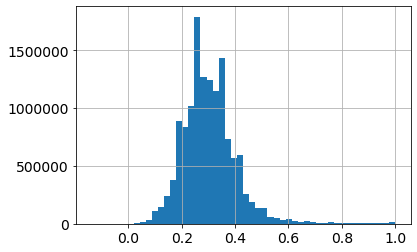

In [1077]:
pd.Series(np.hstack(all_word_sims).round(2)).hist(bins=50)

In [ ]:
for a in all_answers:
    a2 = pd.DataFrame(a['annotated connections'])
    a2['sent_idx_x']

In [70]:
nodes_df = pd.DataFrame(a['nodes'])
nodes_df = nodes_df.loc[lambda df: df['sentence'].str.len() > 2]

In [71]:
token_input, attention_mask, nodes_df = tensorize_df_bert(nodes_df)
output = model(token_input, attention_mask=attention_mask)

In [72]:
output.last_hidden_state.shape 

torch.Size([18, 45, 256])

In [78]:
bert_non_hung_comp = get_all_comparisons(all_answers, get_sentence_similarities_unigram_bert_2)

  0%|          | 0/193 [00:00<?, ?it/s]

In [1034]:
# Hungarian + BERT-Mini: .885 
# Hungarian + BERT-Medium: .887
# Hungarian + RoBERTa: .886 
# Non-Hungarian + BERT-Mini: .89
# Non-Hungarian + BERT-Medium: 

Text(0, 0.5, 'Score')

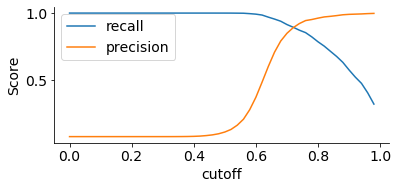

In [79]:
prec_recall = (bert_non_hung_comp
 .groupby('cutoff')
 .mean()
 .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
)
ax = prec_recall.plot(figsize=(6, 2.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Score')

In [80]:
#                   prec * recall
# f1-score = 2 * -----------------
#                   prec + recall

(prec_recall
 .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
 .max()
)

0.8966032001430231

In [985]:
#                   prec * recall
# f1-score = 2 * -----------------
#                   prec + recall

(prec_recall
 .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
 .max()
)

0.8526057298772168

# Regular Sequences

In [83]:
from difflib import SequenceMatcher

In [84]:
def get_sent_char_sim_method_1(nodes_df):
    ## perform comparisons
    sentence_pairs = []
    sents_x = nodes_df.loc[lambda df: df['version'] == df['version'].min()]
    sents_y = nodes_df.loc[lambda df: df['version'] == df['version'].max()]

    sentence_pairs = []
    for s_idx_x, sent_x in sents_x[['sent_idx', 'sentence']].drop_duplicates().itertuples(index=False):
        for s_idx_y, sent_y in sents_y[['sent_idx', 'sentence']].drop_duplicates().itertuples(index=False):
            x_y_sim = SequenceMatcher(None, sent_x, sent_y).ratio()
            sentence_pairs.append({
                'avg_sentence_sim_x': x_y_sim,
                'avg_sentence_sim_y': x_y_sim,
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df

In [ ]:
sent_diff_1_comparisons = get_all_comparisons(all_answers, get_sent_char_sim_method_1)

Text(0, 0.5, 'Score')

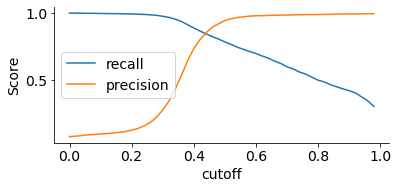

In [745]:
sent_diff_1_prec_recall = (sent_diff_1_comparisons
 .groupby('cutoff')
 .mean()
 .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
)
ax = sent_diff_1_prec_recall.plot(figsize=(6, 2.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Score')

In [748]:
(sent_diff_1_prec_recall
 .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
 .max()
)

0.8586017403337957

In [98]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [103]:
def get_sent_char_sim_method_2(nodes_df):
    tok_method = 'bert'
    sentences = nodes_df['sentence'].tolist()
    tokenized = []
    if tok_method == 'spacy':
        for doc in nlp.pipe(sentences, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
            tokens = list(map(lambda x: x.lemma_, doc))
            tokenized.append(tokens)
    elif tok_method == 'bert':
        for s in sentences:
            tok = tokenizer.encode(s)
            decoded = list(map(tokenizer.decode, tok))
            decoded = decoded[1:-1]
            tokenized.append(decoded)
        
    nodes_df['tokenized_sentences'] = tokenized
    
    ## perform comparisons
    sentence_pairs = []
    sents_x = nodes_df.loc[lambda df: df['version'] == df['version'].min()]
    sents_y = nodes_df.loc[lambda df: df['version'] == df['version'].max()]

    sentence_pairs = []
    for s_idx_x, sent_x in sents_x[['sent_idx', 'tokenized_sentences']].itertuples(index=False):
        for s_idx_y, sent_y in sents_y[['sent_idx', 'tokenized_sentences']].itertuples(index=False):
            x_y_sim = SequenceMatcher(None, sent_x, sent_y).ratio()
            sentence_pairs.append({
                'avg_sentence_sim_x': x_y_sim,
                'avg_sentence_sim_y': x_y_sim,
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df

In [104]:
sent_diff_2_comparisons = get_all_comparisons(all_answers, get_sent_char_sim_method_2)

  0%|          | 0/193 [00:00<?, ?it/s]

Text(0, 0.5, 'Score')

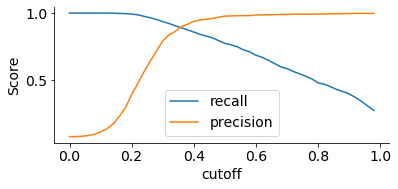

In [105]:
sent_diff_2_prec_recall = (sent_diff_2_comparisons
 .groupby('cutoff')
 .mean()
 .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
)
ax = sent_diff_2_prec_recall.plot(figsize=(6, 2.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Score')

In [106]:
(sent_diff_2_prec_recall
 .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
 .max()
)

0.8965703551843587

In [109]:
from nltk.translate import bleu_score

In [110]:
def get_bleu_comp(nodes_df, weights, *args, **kwargs):
    sentences = nodes_df['sentence'].tolist()
    tokenized = []
    for doc in nlp.pipe(sentences, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        tokens = list(map(lambda x: x.text, doc))
        tokenized.append(tokens)
    nodes_df['tokenized_sentences'] = tokenized
    
    ## perform comparisons
    sentence_pairs = []
    sents_x = nodes_df.loc[lambda df: df['version'] == df['version'].min()]
    sents_y = nodes_df.loc[lambda df: df['version'] == df['version'].max()]

    sentence_pairs = []
    for s_idx_x, sent_x in sents_x[['sent_idx', 'tokenized_sentences']].itertuples(index=False):
        for s_idx_y, sent_y in sents_y[['sent_idx', 'tokenized_sentences']].itertuples(index=False):
            x_sim = bleu_score.sentence_bleu([sent_x], sent_y, weights=weights)
            y_sim = bleu_score.sentence_bleu([sent_y], sent_x, weights=weights)
            sentence_pairs.append({
                'avg_sentence_sim_x': x_sim,
                'avg_sentence_sim_y': x_sim,
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df

In [ ]:
bleu_unigram_comparisons = get_all_comparisons(all_answers, get_bleu_comp, weights=[1, 0, 0, 0])

In [787]:
bleu_bigram_comparisons = get_all_comparisons(all_answers, get_bleu_comp, weights=[0, 1, 0, 0])
bleu_trigram_comparisons = get_all_comparisons(all_answers, get_bleu_comp, weights=[0, 0, 1, 0])
bleu_mixed_bigram_comparisons = get_all_comparisons(all_answers, get_bleu_comp, weights=[.5, .5, 0, 0])
bleu_mixed_trigram_comparisons = get_all_comparisons(all_answers, get_bleu_comp, weights=[.33, .33, .34, 0])

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

In [790]:
for b, k in [
    (bleu_unigram_comparisons, 'bleu unigram'),
    (bleu_bigram_comparisons, 'bleu bigram'),
    (bleu_trigram_comparisons, 'bleu trigram'),
    (bleu_mixed_bigram_comparisons, 'bleu mixed bigram'),
    (bleu_mixed_trigram_comparisons, 'bleu mixed trigram')
]:
    print(k)
    print(
        b
         .groupby('cutoff')
         .mean()
         .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
         .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
         .max()
    )

bleu unigram
0.8673226661124263
bleu bigram
0.8918958525817935
bleu trigram
0.8880751825839377
bleu mixed bigram
0.8883862343439911
bleu mixed trigram
0.8913345439721306


In [ ]:
bleu_bigram_comparisons

# Subsequences

In [1083]:
def lcs(seq_1, seq_2, n, m):
    counter = np.zeros((n + 1, m + 1))
    for i in range(n):
        for j in range(m):
            if seq_1[i] == seq_2[j]:
                c = counter[i][j] + 1
                counter[i+1][j+1] = c
                x_idx_s, x_idx_e = int(i - c + 1), int(i + 1)
                y_idx_s, y_idx_e = int(j - c + 1), int(j + 1)
    return counter


def lcs_mat(sim_mat, threshold=.5):
    n, m = sim_mat.shape
    counter = np.zeros((n + 1, m + 1))
    for i in range(n):
        for j in range(m):
            if sim_mat[i, j] > threshold:
                c = counter[i][j] + 1
                counter[i+1][j+1] = c
                x_idx_s, x_idx_e = int(i - c + 1), int(i + 1)
                y_idx_s, y_idx_e = int(j - c + 1), int(j + 1)
    return counter


def get_all_common_substrings(seq_1=None, seq_2=None, sim_mat=None, output_format='len', minimum_overlap=3, word_sim_thresh=.5):
    """
    `output_format`:
        * = "indices": return raw indices
        * = "subseqs": return substrings from sequences
        * = "len": sum the length
    """
    if seq_1 is not None and seq_2 is not None:
        n = len(seq_1)
        m = len(seq_2)
        mat = lcs(seq_1, seq_2, n, m)
    else:
        n, m = sim_mat.shape
        mat = lcs_mat(sim_mat=sim_mat, threshold=word_sim_thresh)
        
    mat = mat[1:, 1:].copy()
    try:
        accepted_coords = get_substrings_from_matrix(mat, minimum_overlap=minimum_overlap)
    except:
        accepted_coords = {'x':[], 'y':[]}
    # output format
    if output_format == 'indices':
        return accepted_coords
    elif output_format == 'subseqs':
        output_strings = []
        for s, e in accepted_coords['x']:
            output_strings.append(seq_1[s:e])
        return output_strings
    elif output_format == 'len':
        all_len = 0
        for s, e in accepted_coords['x']:
            all_len += e - s

        return all_len


def get_substrings_from_matrix(mat, minimum_overlap):
    accepted_coords = {'x': [], 'y': []}
    str_len = int(mat.max())

    while str_len >= minimum_overlap:
        x_cord, y_cord = np.where(mat == mat.max())
        for x_cord_i, y_cord_i in zip(x_cord, y_cord):
            x_idx_s, x_idx_e = int(x_cord_i - str_len + 1), int(x_cord_i + 1)
            y_idx_s, y_idx_e = int(y_cord_i - str_len + 1), int(y_cord_i + 1)

            # see if there are any zeros in the diagonal - this means that the 
            # substring shares elements with a longer string that was already matched
            diag = mat[range(x_idx_s, x_idx_e), range(y_idx_s, y_idx_e)]
            num_zeros = str_len - np.count_nonzero(diag)
            # if so, correct
            if num_zeros > 0: # 
                mat[range(x_idx_s, x_idx_e), range(y_idx_s, y_idx_e)] = np.maximum(diag - num_zeros, 0)
            else:
                accepted_coords['x'].append((x_idx_s, x_idx_e))
                accepted_coords['y'].append((y_idx_s, y_idx_e))
                mat[x_idx_s:x_idx_e, :] = 0
                mat[:, y_idx_s:y_idx_e] = 0

        # continue 
        str_len = int(mat.max())
    # return 
    return accepted_coords

In [1086]:
def get_subsequence_comp(nodes_df, minimum_overlap=2, *args, **kwargs):
    sentences = nodes_df['sentence'].tolist()
    tokenized = []
    for doc in nlp.pipe(sentences, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        tokens = list(map(lambda x: x.text, doc))
        tokenized.append(tokens)
    nodes_df['tokenized_sentences'] = tokenized
    
    ## perform comparisons
    sentence_pairs = []
    sents_x = nodes_df.loc[lambda df: df['version'] == df['version'].min()]
    sents_y = nodes_df.loc[lambda df: df['version'] == df['version'].max()]

    sentence_pairs = []
    for s_idx_x, sent_x in sents_x[['sent_idx', 'tokenized_sentences']].itertuples(index=False):
        for s_idx_y, sent_y in sents_y[['sent_idx', 'tokenized_sentences']].itertuples(index=False):
            n_common_subseq = get_all_common_substrings(seq_1=sent_x, seq_2=sent_y, minimum_overlap=minimum_overlap)
            sentence_pairs.append({
                'avg_sentence_sim_x': n_common_subseq / len(sent_x) if len(sent_x) > 0 else 0,
                'avg_sentence_sim_y': n_common_subseq / len(sent_y) if len(sent_y) > 0 else 0,
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df


def get_subsequence_comp_bert(nodes_df, minimum_overlap=2, *args, **kwargs):
    nodes_df = pd.DataFrame(a['nodes'])
    token_input, attention_mask, nodes_df = tensorize_df_bert(nodes_df)
    ## Get output
    output = model(token_input, attention_mask=attention_mask)
    ## split words into X and Y
    word_df = []
    for idx, version, s_idx, tokens in nodes_df[['version', 'sent_idx', 'sentence_tokens']].itertuples():
        sentence_vec = output.last_hidden_state[idx]
        word_ids, avg_vecs = avg_across_subwords(sentence_vec, tokens)
        for word_idx in word_ids:
            word_df.append({
                'version': version,
                's_idx': s_idx,
                'w_idx': word_idx,
                'tensor': avg_vecs[word_idx]
            })

    word_df = pd.DataFrame(word_df)
    words_x = word_df.loc[lambda df: df['version'] == df['version'].min()]
    words_y = word_df.loc[lambda df: df['version'] == df['version'].max()]

    ## perform comparisons
    sentence_pairs = []
    for s_idx_x in words_x['s_idx'].drop_duplicates():
        for s_idx_y in words_y['s_idx'].drop_duplicates():
            t_y = np.vstack(words_y.loc[lambda df: df['s_idx'] == s_idx_y]['tensor'].tolist())
            t_x = np.vstack(words_x.loc[lambda df: df['s_idx'] == s_idx_x]['tensor'].tolist())
            # 
            x_y_sim = cosine_similarity(t_x, t_y)    
            n_common_subseq = get_all_common_substrings(
                sim_mat=x_y_sim,
                minimum_overlap=minimum_overlap
            )
            sentence_pairs.append({
                'avg_sentence_sim_x': n_common_subseq / len(words_x),
                'avg_sentence_sim_y': n_common_subseq / len(words_y),
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df

In [1087]:
subseq_comps = get_all_comparisons(all_answers, get_subsequence_comp_bert, minimum_overlap=2)

  0%|          | 0/193 [00:00<?, ?it/s]

In [1088]:
(
        subseq_comps
         .groupby('cutoff')
         .mean()
         .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
         .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
         .max()
    )

0.5470755372782103

In [1095]:
from pyemd import emd
import os
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [1096]:
d1 = "Obama speaks to the media in Illinois"
d2 = "The President addresses the press in Chicago"

vect = CountVectorizer(stop_words="english").fit([d1, d2])
print("Features:",  ", ".join(vect.get_feature_names()))

Features: addresses, chicago, illinois, media, obama, president, press, speaks


In [ ]:
if not os.path.exists("data/embed.dat"):
    print("Caching word embeddings in memmapped format...")
    from gensim.models.word2vec import Word2Vec
    from gensim.models.keyedvectors import KeyedVectors
    wv = KeyedVectors.load_word2vec_format('tmp/GoogleNews-vectors-negative300.bin.gz', binary=True)
    wv.init_sims(replace=True) 
    print("finish loading word2vec")
    fp = np.memmap("tmp/embed.dat", dtype=np.double, mode='w+', shape=wv.syn0.shape)
    fp[:] = wv.syn0[:]
    with open("tmp/embed.vocab", "w") as f:
        for _, w in sorted((voc.index, word) for word, voc in wv.vocab.items()):
            print(w, file=f)
    del fp, wv

W = np.memmap("tmp/embed.dat", dtype=np.double, mode="r", shape=(3000000, 300))
with open("tmp/embed.vocab") as f:
    vocab_list = map(str.strip, f.readlines())

Caching word embeddings in memmapped format...


In [ ]:
vocab_dict = {w: k for k, w in enumerate(vocab_list)}

In [1098]:
from sklearn.metrics import euclidean_distances
W_ = W[[vocab_dict[w] for w in vect.get_feature_names()]]
D_ = euclidean_distances(W_)
print("d(addresses, speaks) = {:.2f}".format(D_[0, 7]))
print("d(addresses, chicago) = {:.2f}".format(D_[0, 1]))

NameError: name 'W' is not defined

In [1089]:
# pyemd needs double precision input
v_1 = v_1.astype(np.double)
v_2 = v_2.astype(np.double)
v_1 /= v_1.sum()
v_2 /= v_2.sum()
D_ = D_.astype(np.double)
D_ /= D_.max()  # just for comparison purposes
print("d(doc_1, doc_2)  = {:.2f}".format(emd(v_1, v_2, D_)))

NameError: name 'v_1' is not defined

In [1043]:
(subseq_comps
         .groupby('cutoff')
         .mean()
         .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
         .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
         .max())

0.8608680927922335

In [ ]:
    ## Get bert embeddings
    token_input, attention_mask, nodes_df = tensorize_df_bert(nodes_df)
    output = model(token_input, attention_mask=attention_mask)

    ## split words into X and Y
    word_df = []
    for idx, version, s_idx, tokens in nodes_df[['version', 'sent_idx', 'sentence_tokens']].itertuples():
        sentence_vec = output.last_hidden_state[idx]
        word_ids, avg_vecs = avg_across_subwords(sentence_vec, tokens)
        for word_idx in word_ids:
            word_df.append({
                'version': version,
                's_idx': s_idx,
                'w_idx': word_idx,
                'tensor': avg_vecs[word_idx]
            })
    
    word_df = pd.DataFrame(word_df)
    words_x = word_df.loc[lambda df: df['version'] == df['version'].min()]
    words_y = word_df.loc[lambda df: df['version'] == df['version'].max()]
